In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, RobustScaler
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense
from tensorflow.keras.regularizers import l1, l2
from keras_tuner import BayesianOptimization
from tensorflow.keras.callbacks import ReduceLROnPlateau
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
import gc

2023-12-02 11:06:07.970810: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-12-02 11:06:08.005481: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-12-02 11:06:08.141033: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-02 11:06:08.141076: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-02 11:06:08.142059: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to regi

In [2]:
df=pd.read_csv('logKH_CH4.csv')

In [3]:
target='logKH_CH4'
y=df[target]
X=df.drop(target,axis=1)

In [4]:
print(y.shape,X.shape)

(9525,) (9525, 15)


In [33]:
scaler=StandardScaler()
X_scaled=scaler.fit_transform(X)

In [34]:
# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)



In [8]:
def build_model(hp):
    model = keras.Sequential()

    # Tuning the number of units in the first Dense layer
    hp_units = hp.Int('units', min_value=32, max_value=2048, step=32)
    model.add(Dense(units=hp_units, activation='relu', input_shape=(X_train.shape[1],)))
    model.add(Dropout(0.2))

    # Adding L1 regularization
    hp_reg_l1 = hp.Choice('l1_reg', values=[ 5e-7,1e-5,5e-6, 1e-6,1e-4,1e-3,1e-7])
    model.add(Dense(units=hp_units, activation='relu', kernel_regularizer=l1(hp_reg_l1)))
    model.add(Dropout(0.2))

    # Adding L2 regularization
    hp_reg_l2 = hp.Choice('l2_reg', values=[1e-1,5e-1, 5e-2,1e-3,1e-4,1e-2])
    model.add(Dense(units=hp_units, activation='relu', kernel_regularizer=l2(hp_reg_l2)))
    model.add(Dropout(0.2))

    # Tuning the learning rate for the optimizer
    hp_learning_rate = hp.Choice('learning_rate', values=[ 1e-2,1e-3,1e-4, 1e-5, 1e-6])

    model.add(Dense(1))
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
                  loss='mean_squared_error',
                  metrics=['mean_squared_error'])

    return model

# Define the Learning Rate Scheduler
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.7, patience=7, verbose=1, min_delta=1e-7) 

# Define the tuner and start the search
tuner = BayesianOptimization(
    build_model,
    objective='val_mean_squared_error',
    max_trials=10,  # set this to a high value for thorough search
    directory='logKH_CH4_output_dir',
    project_name='logKH_CH4',
    seed=42,  # it's important to set a seed for reproducibility
    num_initial_points=10,  # number of random trials before Bayesian optimization starts
)

# Early stopping callback
stop_early = keras.callbacks.EarlyStopping(monitor='val_loss', patience=15)

# Search for the optimal hyperparameters
tuner.search(X_train, y_train,
             epochs=250,
             validation_split=0.2,
             callbacks=[stop_early, reduce_lr])

# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is {best_hps.get('units')} and the optimal learning rate for the optimizer
is {best_hps.get('learning_rate')}. The optimal L1 regularization strength is {best_hps.get('l1_reg')}
and the optimal L2 regularization strength is {best_hps.get('l2_reg')}.
""")

# Build the model with the optimal hyperparameters
model = tuner.hypermodel.build(best_hps)

# Retrain the model
history = model.fit(X_train, y_train, epochs=500, validation_split=0.2, callbacks=[reduce_lr])

val_acc_per_epoch = history.history['val_mean_squared_error']
best_epoch = val_acc_per_epoch.index(min(val_acc_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch,))

# Re-instantiate the hypermodel and train it with the optimal number of epochs from above.
hypermodel = tuner.hypermodel.build(best_hps)

# Retrain the model
hypermodel.fit(X_train, y_train, epochs=best_epoch, validation_split=0.2, callbacks=[reduce_lr])

# Save the model
hypermodel.save('logKH_CH4.h5') 

# Clear session to free up some memory
keras.backend.clear_session()

# Trigger garbage collection
gc.collect()


Search: Running Trial #1

Value             |Best Value So Far |Hyperparameter
736               |736               |units
5e-07             |5e-07             |l1_reg
0.5               |0.5               |l2_reg
0.001             |0.001             |learning_rate

Epoch 1/250
1382/1382 [==============================] - 8s 5ms/step - loss: 4.8173 - mean_squared_error: 0.0066 - val_loss: 0.0102 - val_mean_squared_error: 8.8128e-04 - lr: 0.0010
Epoch 2/250
1382/1382 [==============================] - 7s 5ms/step - loss: 0.0096 - mean_squared_error: 0.0017 - val_loss: 0.0070 - val_mean_squared_error: 5.9982e-04 - lr: 0.0010
Epoch 3/250
1382/1382 [==============================] - 7s 5ms/step - loss: 0.0072 - mean_squared_error: 0.0015 - val_loss: 0.0049 - val_mean_squared_error: 6.4441e-04 - lr: 0.0010
Epoch 4/250
1382/1382 [==============================] - 7s 5ms/step - loss: 0.0051 - mean_squared_error: 0.0010 - val_loss: 0.0042 - val_mean_squared_error: 7.1093e-04 - lr: 0.0010
Epoch

KeyboardInterrupt: 

In [7]:
loaded_model = load_model('logKH_CH4.h5')


In [13]:
y_pred=loaded_model.predict(X_test)


432/432 [==============================] - 1s 1ms/step


/tmp/ipykernel_5361/3859232716.py:12: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=3, color='red')


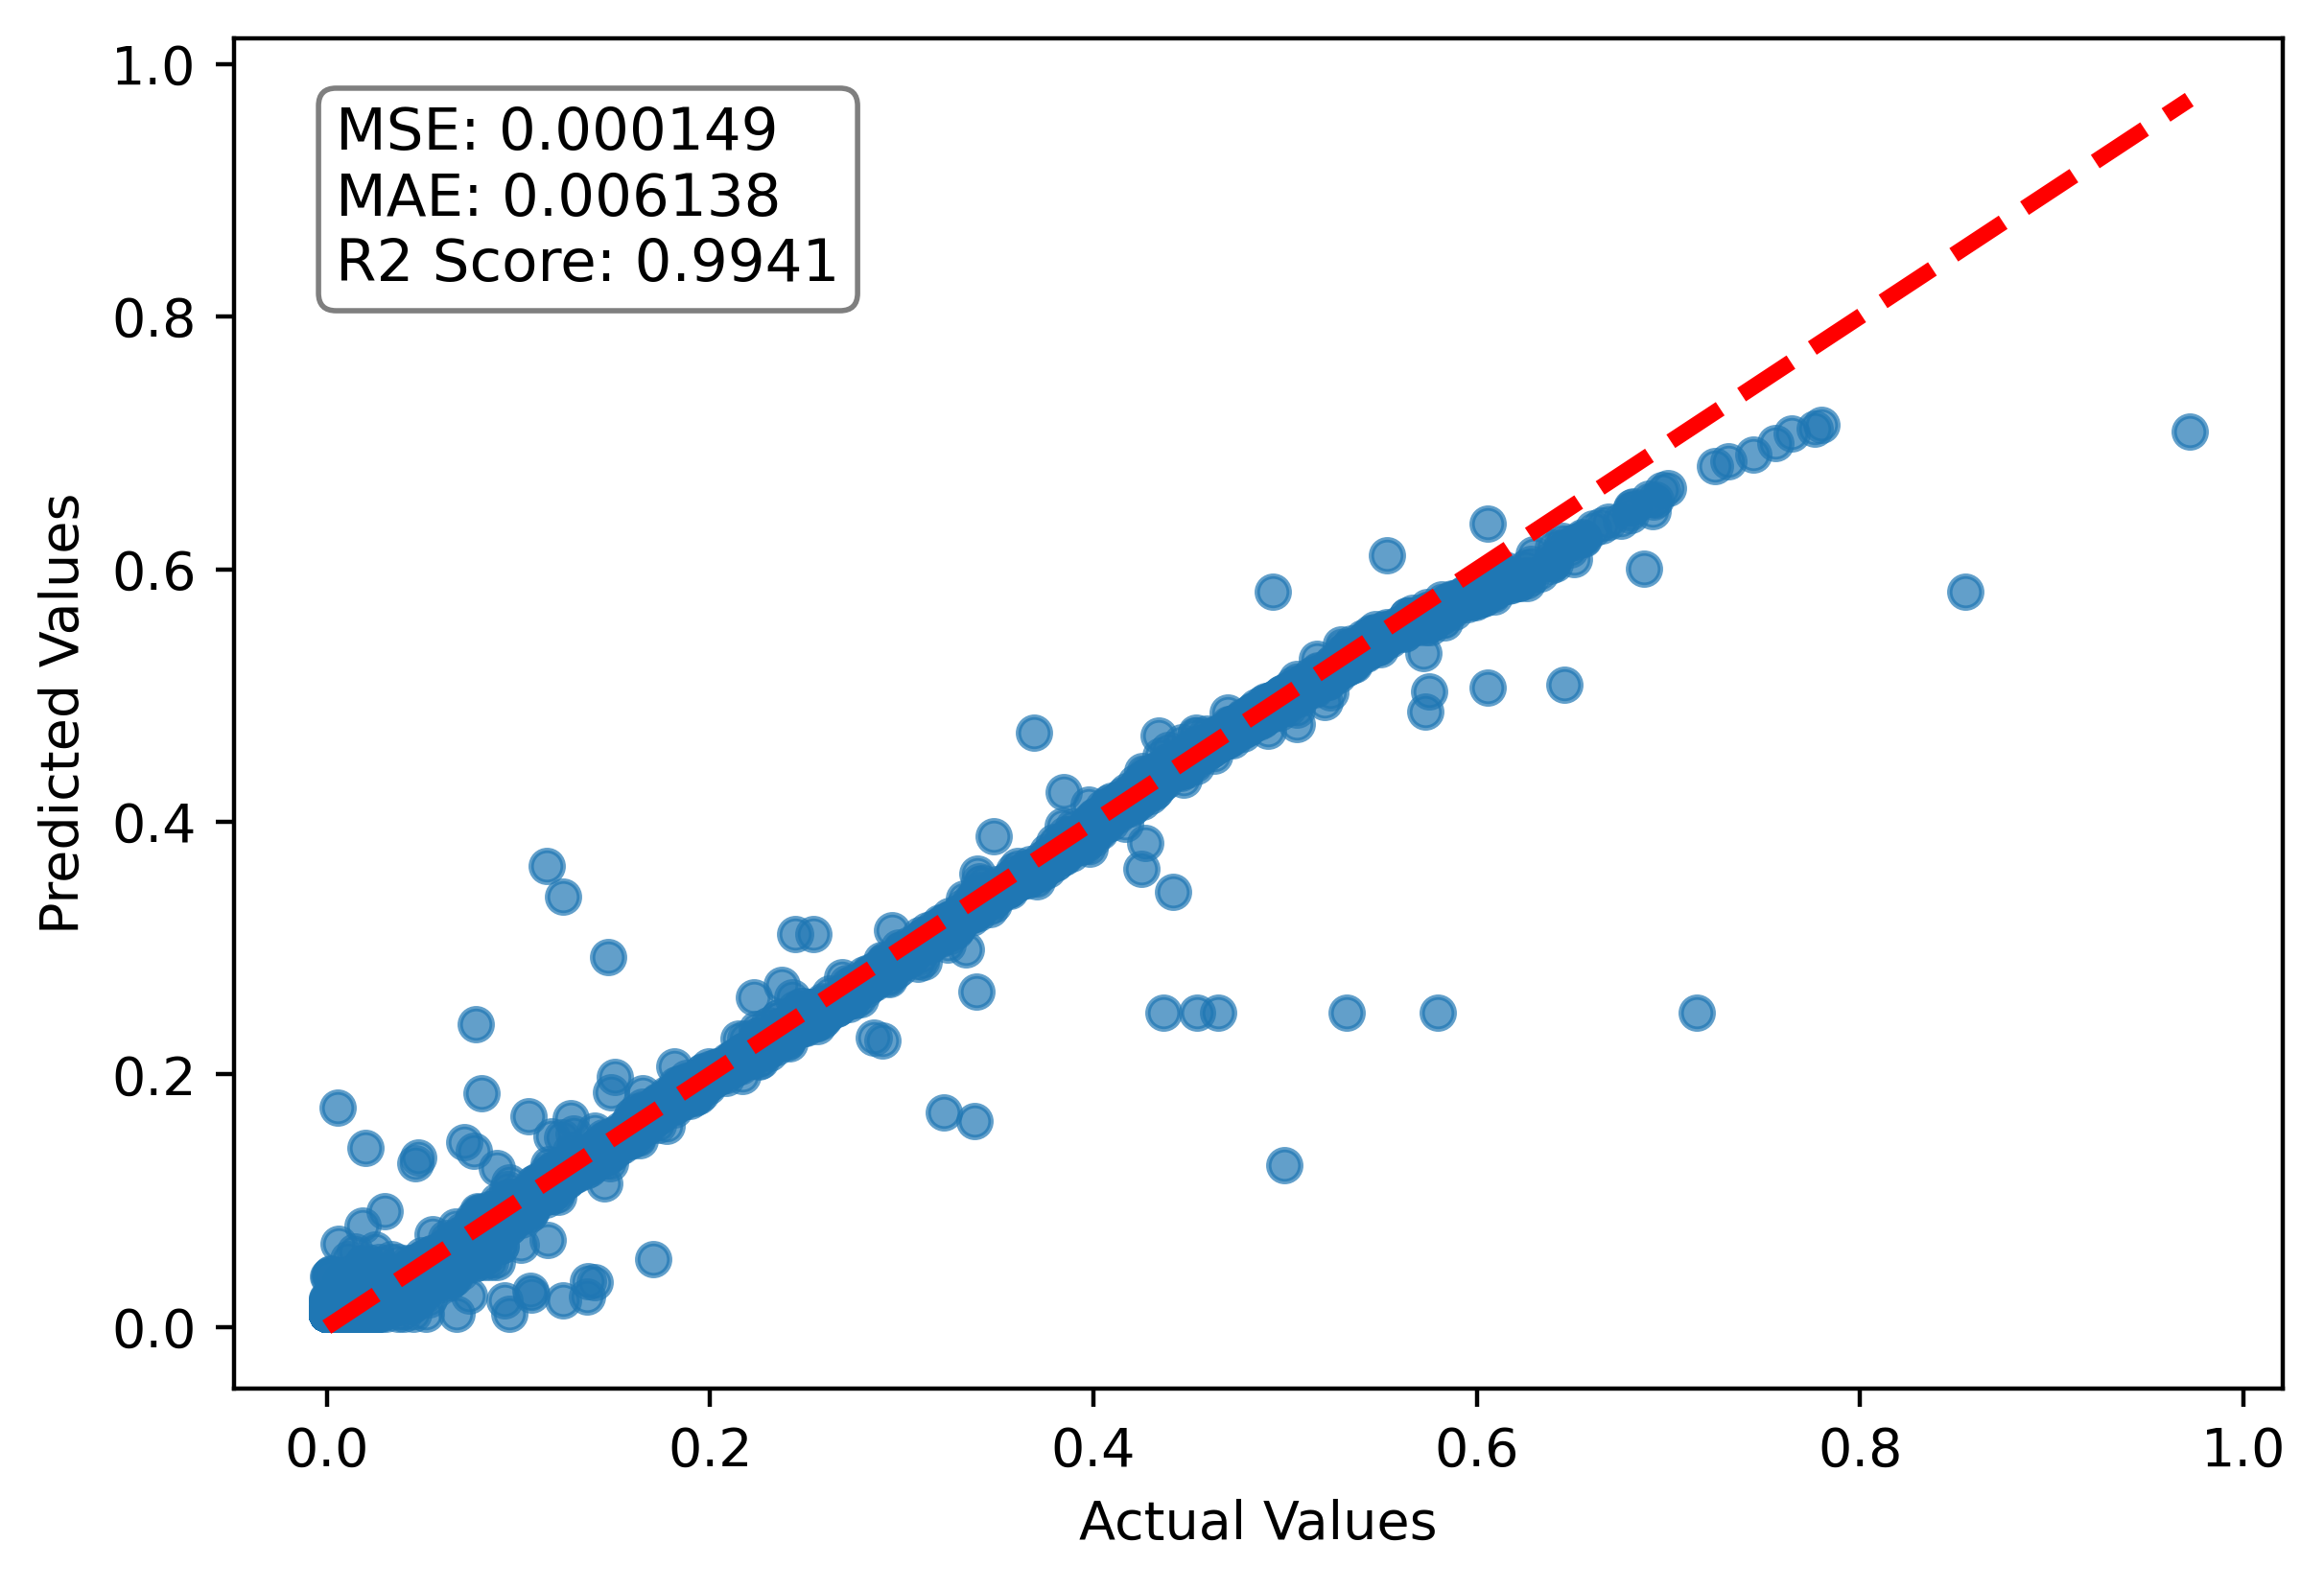

In [82]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Your y_test and y_pred data here

# Calculate metrics
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

plt.figure(figsize=(6, 4),dpi=400)
plt.scatter(y_test, y_pred, alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=3, color='red')
plt.xlabel("Actual Values",fontsize=10)
plt.ylabel("Predicted Values",fontsize=10)
metrics_text = f"MSE: {mse:.6f}\nMAE: {mae:.6f}\nR2 Score: {r2:.4f}"
plt.annotate(metrics_text, xy=(0.05, 0.95), xycoords='axes fraction', 
         fontsize=11, ha='left', va='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.5))    
# Save the figure
# model_name_safe = "".join(c for c in model_name if c.isalnum() or c.isspace()).replace(" ", "_")
plt.subplots_adjust(right=0.99)  # Adjust as needed, values closer to 1 will reduce the right margin
plt.subplots_adjust(left=0.1)
plt.subplots_adjust(top=0.99)

plt.savefig('logKH_CH4.eps', dpi=500)


In [16]:
model=loaded_model

In [50]:
sensitivity_analysis = []
perturbation_amount = 0.25

for i in range(X_train.shape[1]):
    X_perturbed = X_test.copy()
    X_perturbed[:, i] += perturbation_amount

    y_perturbed = model.predict(X_perturbed)
    sensitivity = np.abs((y_perturbed - y_pred) / perturbation_amount)
    sensitivity_analysis.append(sensitivity.mean())

432/432 [==============================] - 1s 1ms/step


In [51]:
sensitivity_analysis = np.array(sensitivity_analysis)

In [52]:
feature_names = X.columns.tolist()

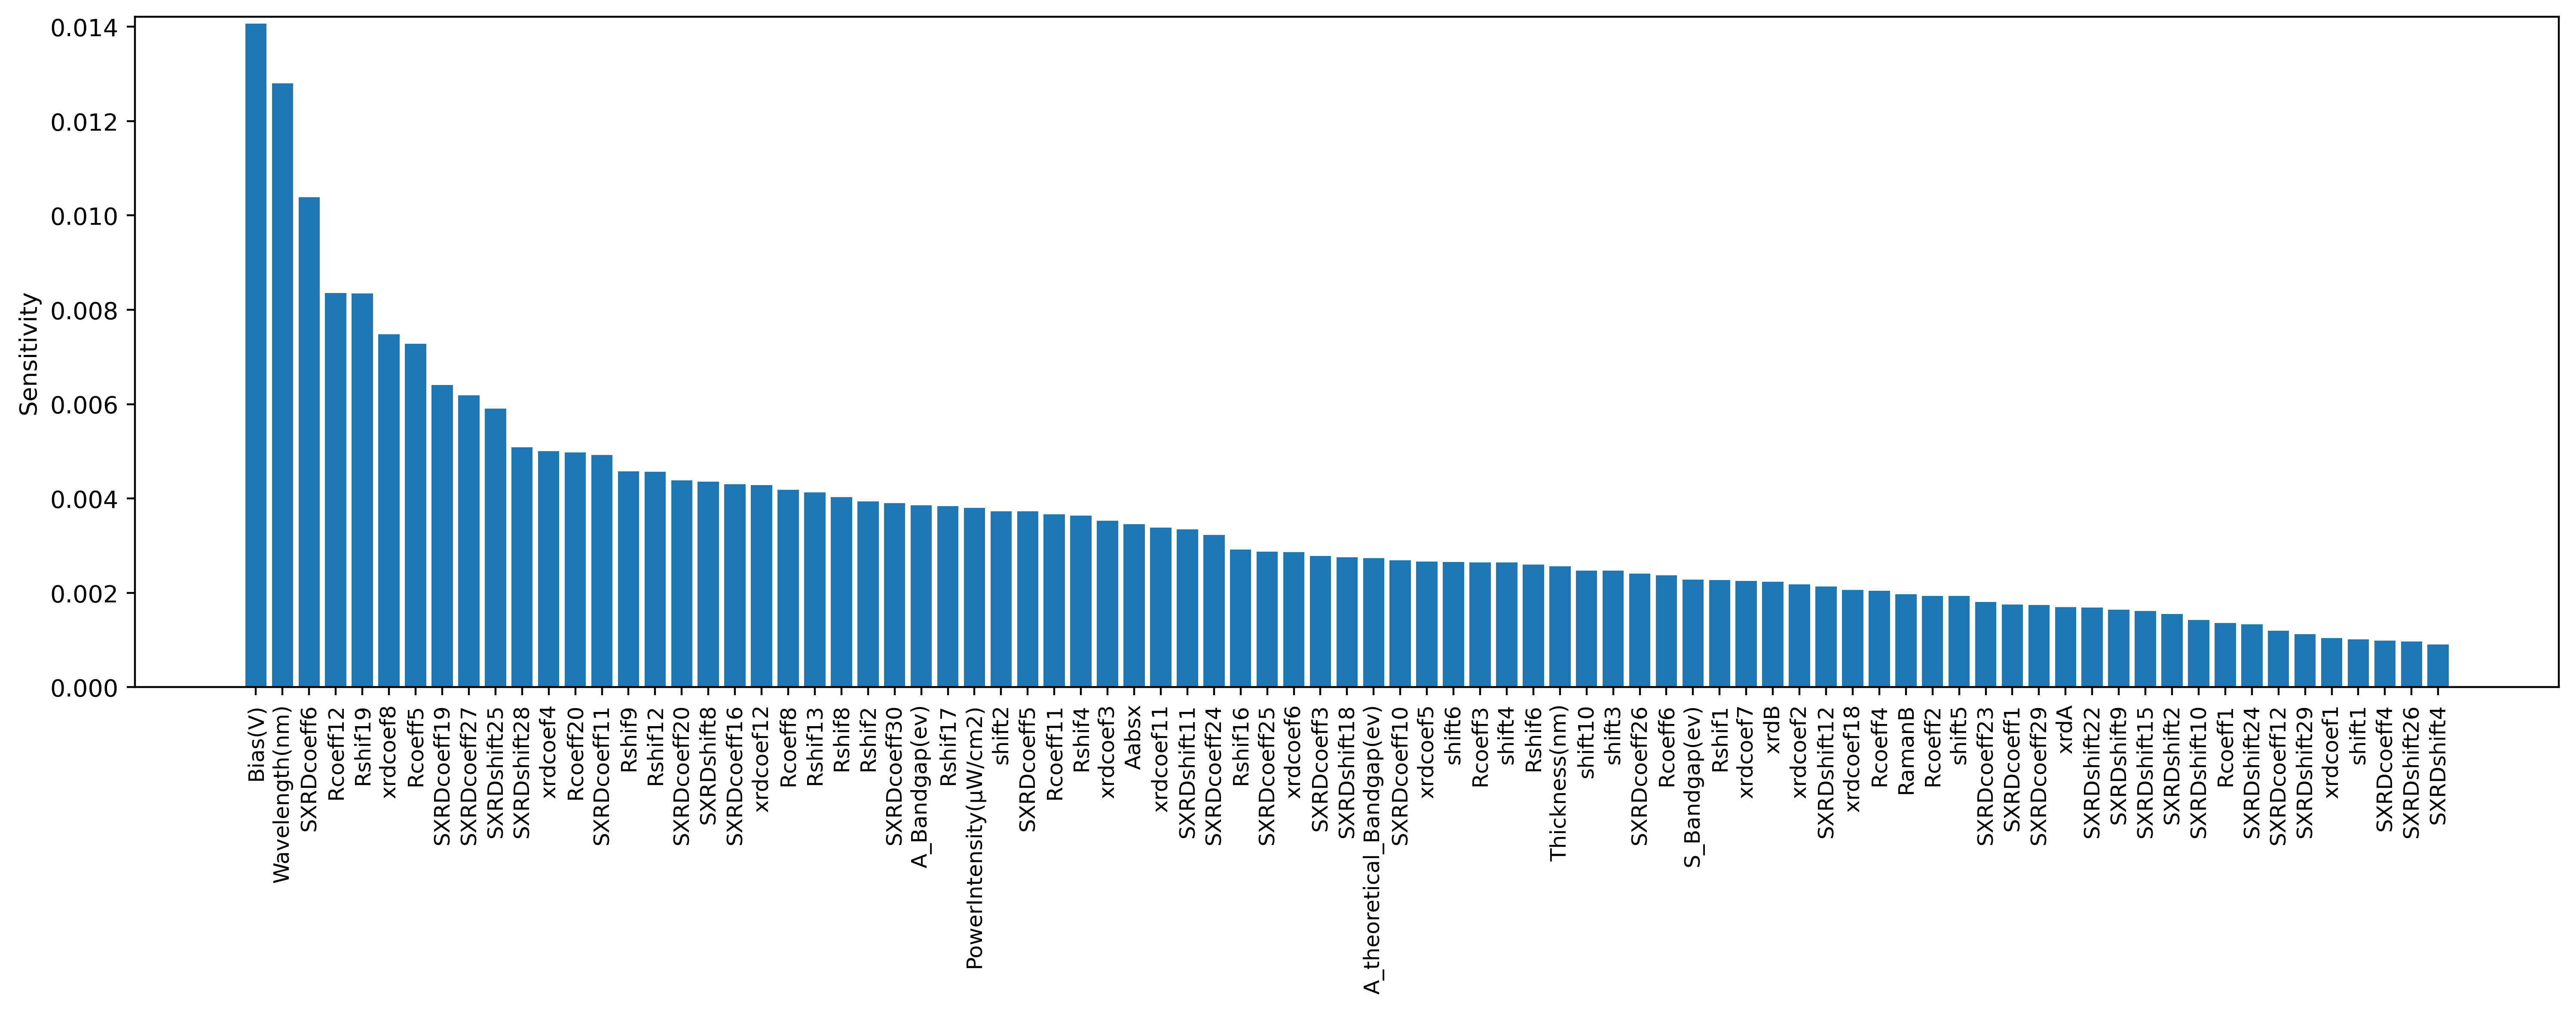

In [53]:
plt.figure(figsize=(15, 6), dpi=400)  # Adjust the figsize as needed
top_features_sensitivity = np.argsort(sensitivity_analysis)[-83:][::-1]  # Reverse the order
top_feature_names = [feature_names[i] for i in top_features_sensitivity]  # Do not reverse the order
bars = plt.bar(range(len(top_features_sensitivity)), [sensitivity_analysis[i] for i in top_features_sensitivity])

# Calculate the maximum sensitivity value
max_sensitivity = max(sensitivity_analysis)

plt.xticks(range(len(top_features_sensitivity)), top_feature_names, fontsize=9, rotation='vertical')
plt.ylabel("Sensitivity", fontsize=10)
plt.ylim(0, 1.01 * max_sensitivity)  # Adjust the y-limit

# Save the sensitivity analysis figure
plt.subplots_adjust(top=0.95)  # Adjust as needed, values closer to 1 will reduce the top margin
plt.subplots_adjust(bottom=0.3)
plt.subplots_adjust(right=0.99)
plt.subplots_adjust(left=0.05)


plt.savefig('logKH_CH4_sensitivity.eps', dpi=500)

plt.show()
